In [9]:
import gzip
import sys
import time
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
def get_data(sample_size, pathX, pathY):
    f = gzip.open(pathX, 'r')

    # read off unimportant bytes describing file protocol
    image_size = 28 * 28
    protocol_length = 16
    f.read(protocol_length)

    X = f.read(image_size * sample_size)
    X = np.frombuffer(X, dtype=np.uint8).astype(np.float32)
    X = X.reshape(sample_size, image_size)

    f = gzip.open(pathY, 'r')

    protocol_length = 8
    f.read(protocol_length)
    Y_temp = f.read(sample_size)
    Y_temp = np.frombuffer(Y_temp, dtype=np.uint8)

    Y = np.zeros([sample_size, 10], dtype='f')
    for sample in range(sample_size):
        Y[sample][Y_temp[sample]] = 1.0

    return [np.array([data / 127.5 for data in X], dtype='f') - 1.0, Y]

In [3]:
class Network:
    def __init__(self, layers):
        self.layers = layers
        self.w = []
        self.b = []
        for layer in range(1, len(layers)):
            self.w.append((2.0 * (np.random.randint(1e9, size=[layers[layer], layers[layer - 1]]) / 1e9)) - 1.0)
            self.b.append(((2.0 * (np.random.randint(1e9, size=[layers[layer]]) / 1e9)) - 1.0).reshape([layers[layer], 1]))

    def sigmoid(self, data):
        epsilon = 1e-8
        return 1.0 / (1.0 + np.exp(-data + epsilon))

    def sigmoid_derivative(self, data):
        temp = self.sigmoid(data)
        return temp * (1 - temp)

    def tanh(self, data):
        return np.tanh(data)
    
    def tanh_derivative(self, data):
        return 1 - np.tanh(data) ** 2

    def activation(self, data):
        return self.tanh(data)

    def activation_derivative(self, data):
        return self.tanh_derivative(data)

    def backPropFast(self, train_X, train_Y, eta, lambd, p_keep):
        m = len(train_X[0])

        gradients_w = [np.zeros([self.layers[layer], self.layers[layer - 1]], dtype='f') for layer in range(1, len(self.layers))]
        gradients_b = [np.zeros([self.layers[layer]], dtype='f') for layer in range(1, len(self.layers))]
        activations = [train_X]
        zs = [train_X]

        last_layer = len(self.layers) - 2

        for layer in range(len(self.layers) - 1):
            zs.append(np.dot(self.w[layer], activations[-1]) + self.b[layer])
            if layer == last_layer: activations.append(self.sigmoid(zs[-1]))
            else: activations.append(self.activation(zs[-1]))
            keeper = np.random.rand(activations[-1].shape[0], activations[-1].shape[1]) < p_keep[layer + 1]
            activations[-1] = np.multiply(activations[-1], keeper)
            # print(np.max(activations[-1]))
            # print(np.min(activations[-1]))
            # exit(0)

        delta_l = (activations[-1] - train_Y) * self.sigmoid_derivative(zs[-1])
        gradients_b[-1] = delta_l.sum(axis=1)
        gradients_w[-1] = np.dot(delta_l, np.transpose(activations[-2])) + lambd * self.w[-1] / float(m)

        for layer in range(len(self.layers) - 2, 0, -1):
            delta_l = np.dot(np.transpose(self.w[layer]), delta_l) * self.activation_derivative(zs[layer])
            gradients_b[layer - 1] += delta_l.sum(axis=1)
            gradients_w[layer - 1] += np.dot(delta_l, np.transpose(activations[layer - 1])) + lambd * self.w[layer - 1] / float(m)
        
        for layer in range(len(gradients_b)):
            self.w[layer] -= eta * gradients_w[layer] / float(m)
            self.b[layer] -= eta * gradients_b[layer].reshape([len(gradients_b[layer]), 1]) / float(m)

    def train(self, train_X, train_Y, batch_size, eta=1.0, lambd=0.0, p_keep=None):
        m = len(train_X[0]) #60000
        if not p_keep: p_keep = [1.0 for i in range(len(self.layers))]
        for batch in range(int(m / batch_size)):
            X = train_X[ : , batch * batch_size : (batch + 1) * batch_size]
            Y = train_Y[ : , batch * batch_size : (batch + 1) * batch_size]
            self.backPropFast(X, Y, eta, lambd, p_keep)

    def getAccuracy(self, X, Y):
        last_layer = len(self.layers) - 2
        for layer in range(len(self.layers) - 1):
            if layer == last_layer: X = self.sigmoid(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))
            else: X = self.activation(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))
        predictions = np.argmax(X, 0)
        Y = np.argmax(Y, 0)
        return (predictions == Y).sum() / float(len(Y))

    def getLoss(self, X, Y):
        last_layer = len(self.layers) - 2
        for layer in range(len(self.layers) - 1):
            if layer == last_layer: X = self.sigmoid(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))
            else: X = self.activation(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))


In [11]:
train_size = 1000
test_size = 10000

train_X, train_Y = get_data(train_size, 'MNIST_Dataset/train-images-idx3-ubyte.gz', 'MNIST_Dataset/train-labels-idx1-ubyte.gz')
test_X, test_Y = [np.transpose(a) for a in get_data(test_size, 'MNIST_Dataset/t10k-images-idx3-ubyte.gz', 'MNIST_Dataset/t10k-labels-idx1-ubyte.gz')]

In [23]:
layers = [784, 256, 32, 10]
batch_size = 10
eta = 1.0
epochs = 100
lambd = 0.0
p_keep = [1.0, 1.0, 1.0, 1.0]

network = Network(layers)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100


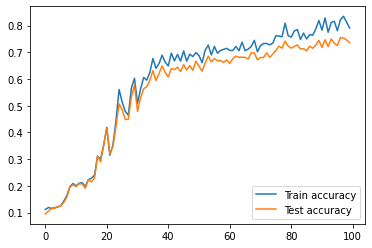

In [24]:
train_accuracies = np.zeros([epochs], dtype='f')
test_accuracies = np.zeros([epochs], dtype='f')

for epoch in range(epochs):
    print("Epoch:", epoch + 1)
    train_X, train_Y = shuffle(train_X, train_Y)
    start_time = time.perf_counter()
    network.train(np.transpose(train_X), np.transpose(train_Y), batch_size, eta, lambd, p_keep)
    train_accuracies[epoch] = network.getAccuracy(np.transpose(train_X), np.transpose(train_Y))
    test_accuracies[epoch] = network.getAccuracy(test_X, test_Y)

plt.plot(np.arange(epochs), train_accuracies, label="Train accuracy")
plt.plot(np.arange(epochs), test_accuracies, label="Test accuracy")
plt.legend(loc="lower right")
plt.show()
    # print(f"Train Accuracy = {network.getAccuracy(np.transpose(train_X), np.transpose(train_Y)):0.3f}")
    # print(f"Test Accuracy = {network.getAccuracy(test_X, test_Y):0.3f}")
    # print(f"Time taken in this epoch = {time.perf_counter() - start_time:0.1f} seconds")

# print("average weight:", sum([np.sum(np.abs(network.w[layer])) for layer in range(len(layers) - 1)]) / sum([np.size(network.w[layer]) for layer in range(len(layers) - 1)]))